<center><h1>Last_First_HW8</h1></center>

Name: Praveen Saravanan
<br>
Github Username: Michael-on-the-Microphone
<br>
USC ID: 7939976839

## 1. Supervised, Semi-Supervised, and Unsupervised Learning

Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)
from sklearn.cluster import KMeans, SpectralClustering

In [2]:
import warnings
warnings.filterwarnings('ignore')

### (a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set

In [3]:
DATA_PATH = "../data/wdbc.data"

features = [
    f"{feat}_{stat}"
    for feat in [
        'radius','texture','perimeter','area','smoothness',
        'compactness','concavity','concave_points','symmetry','fractal_dim'
    ]
    for stat in ['mean','se','worst']
]
cols = ['id','diagnosis'] + features

df = pd.read_csv(DATA_PATH, header=None, names=cols)
df['y'] = df['diagnosis'].map({'B':0,'M':1})

X = df[features].values
y = df['y'].values

### (b) Monte-Carlo Simulation

#### (i) Supervised Learning

In [4]:
def supervised_experiment(X, y, M=30, test_size=0.2):
    stats = {'train': [], 'test': []}

    for seed in range(M):
        X_tr, X_te, y_tr, y_te = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=seed
        )
        scaler = StandardScaler().fit(X_tr)
        X_tr_s = scaler.transform(X_tr)
        X_te_s = scaler.transform(X_te)

        grid = GridSearchCV(
            LinearSVC(penalty='l1', dual=False, max_iter=5000),
            { 'C': np.logspace(-3,3,10) },
            cv=StratifiedKFold(5, shuffle=True, random_state=seed),
            scoring='f1'
        ).fit(X_tr_s, y_tr)
        model = grid.best_estimator_

        for X_, y_, key in [(X_tr_s, y_tr, 'train'), (X_te_s, y_te, 'test')]:
            y_pred  = model.predict(X_)
            y_score = model.decision_function(X_)
            stats[key].append({
                'accuracy':  accuracy_score(y_, y_pred),
                'precision': precision_score(y_, y_pred),
                'recall':    recall_score(y_, y_pred),
                'f1':        f1_score(y_, y_pred),
                'auc':       roc_auc_score(y_, y_score)
            })

    df_tr = pd.DataFrame(stats['train']).mean()
    df_te = pd.DataFrame(stats['test']).mean()
    return df_tr, df_te, model, scaler, X_tr_s, y_tr, X_te_s, y_te

Train confusion matrix:
 [[284   1]
 [  3 167]]
Test confusion matrix:
 [[69  3]
 [ 2 40]]


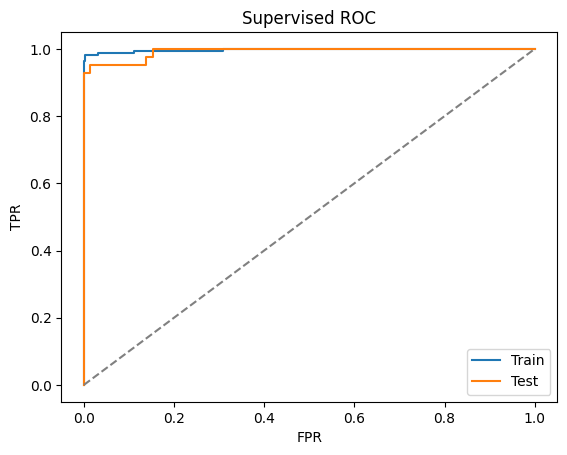

Supervised (test):
 accuracy     0.966374
precision    0.971106
recall       0.937302
f1           0.953406
auc          0.993100
dtype: float64


In [5]:
df_train_sup, df_test_sup, model_sup, scaler_sup, X_tr_s, y_tr, X_te_s, y_te = supervised_experiment(X, y, M=1)

for name, (X_, y_) in [('Train',(X_tr_s,y_tr)), ('Test',(X_te_s,y_te))]:
    y_score = model_sup.decision_function(X_)
    fpr, tpr, _ = roc_curve(y_, y_score)
    plt.plot(fpr, tpr, label=name)
    cm = confusion_matrix(y_, model_sup.predict(X_))
    print(f"{name} confusion matrix:\n", cm)
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.legend(); plt.title('Supervised ROC')
plt.show()

df_tr_mc, df_te_mc, *_ = supervised_experiment(X, y, M=30)
print("Supervised (test):\n", df_te_mc)

#### (ii) Semi-Supervised Learning/ Self-training

##### (A)

In [6]:
def self_training_experiment(X, y, M=30, test_size=0.2):
    stats = {'train': [], 'test': []}

    for seed in range(M):
        X_t, X_test, y_t, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=seed
        )
        idx_pos = np.where(y_t==1)[0]; idx_neg = np.where(y_t==0)[0]
        np.random.shuffle(idx_pos); np.random.shuffle(idx_neg)
        labeled = np.hstack([idx_pos[:len(idx_pos)//2], idx_neg[:len(idx_neg)//2]])
        unlabeled = list(set(range(len(y_t))) - set(labeled))

        scaler = StandardScaler().fit(X_t[labeled])
        X_lab = scaler.transform(X_t[labeled])
        y_lab = y_t[labeled]
        X_un = scaler.transform(X_t[unlabeled])

        model = None
        while len(unlabeled) > 0:
            grid = GridSearchCV(
                LinearSVC(penalty='l1', dual=False, max_iter=5000),
                {'C': np.logspace(-3,3,5)},
                cv=5, scoring='f1'
            ).fit(X_lab, y_lab)
            model = grid.best_estimator_
            distances = np.abs(model.decision_function(X_un))
            farthest_idx = np.argmax(distances)
            X_lab = np.vstack([X_lab, X_un[farthest_idx:farthest_idx+1]])
            y_lab = np.hstack([y_lab, model.predict(X_un[farthest_idx:farthest_idx+1])])
            X_un = np.delete(X_un, farthest_idx, axis=0)
            unlabeled.pop(farthest_idx)

        for X_, y_, key in [
            (X_lab, y_lab, 'train'),
            (scaler.transform(X_test), y_test, 'test')
        ]:
            y_pred  = model.predict(X_)
            y_score = model.decision_function(X_)
            stats[key].append({
                'accuracy':  accuracy_score(y_, y_pred),
                'precision': precision_score(y_, y_pred),
                'recall':    recall_score(y_, y_pred),
                'f1':        f1_score(y_, y_pred),
                'auc':       roc_auc_score(y_, y_score)
            })

    return pd.DataFrame(stats['train']).mean(), pd.DataFrame(stats['test']).mean()

##### (B)

In [7]:
df_tr_semi, df_te_semi = self_training_experiment(X, y, M=30)
print("Semi‑supervised (test):\n", df_te_semi)

Semi‑supervised (test):
 accuracy     0.955848
precision    0.954653
recall       0.926190
f1           0.939442
auc          0.987831
dtype: float64


#### (iii) Unsupervised Learning

##### (A)

In [8]:
def kmeans_experiment(X, y, M=30, test_size=0.2, closest=30):
    stats = {'train': [], 'test': []}

    for seed in range(M):
        X_tr, X_te, y_tr, y_te = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=seed
        )
        kmeans = KMeans(n_clusters=2, n_init=10, random_state=seed).fit(X_tr)
        centers = kmeans.cluster_centers_

        labels_map = {}
        for c in (0,1):
            dists = np.linalg.norm(X_tr - centers[c], axis=1)
            idx30 = np.argsort(dists)[:closest]
            labels_map[c] = int(round(y_tr[idx30].mean()))

        def eval_split(X_, y_, key):
            preds = np.array([labels_map[c] for c in kmeans.predict(X_)])
            d0 = np.linalg.norm(X_ - centers[0], axis=1)
            d1 = np.linalg.norm(X_ - centers[1], axis=1)
            score = d0 - d1
            stats[key].append({
                'accuracy':  accuracy_score(y_, preds),
                'precision': precision_score(y_, preds),
                'recall':    recall_score(y_, preds),
                'f1':        f1_score(y_, preds),
                'auc':       roc_auc_score(y_, score)
            })

        eval_split(X_tr, y_tr, 'train')
        eval_split(X_te, y_te, 'test')

    return pd.DataFrame(stats['train']).mean(), pd.DataFrame(stats['test']).mean()

##### (B)

In [9]:
df_tr_km, df_te_km = kmeans_experiment(X, y, M=30)
print("K-means Classifier (test):\n", df_te_km)

K-means Classifier (test):
 accuracy     0.854094
precision    0.996235
recall       0.606349
f1           0.752364
auc          0.780633
dtype: float64


#### (iv) Spectral Clustering

In [10]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def spectral_experiment(X, y, M=30, test_size=0.2, gamma=1.0):
    stats = {'train': [], 'test': []}

    for seed in range(M):
        X_tr, X_te, y_tr, y_te = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=seed
        )
        spec = SpectralClustering(
            n_clusters=2, affinity='rbf', gamma=gamma,
            assign_labels='kmeans', random_state=seed
        )
        lab_tr = spec.fit_predict(X_tr)
        lab_te = spec.fit_predict(X_te)

        for lab, X_, y_, key in [
            (lab_tr, X_tr, y_tr, 'train'),
            (lab_te, X_te, y_te, 'test')
        ]:
            stats[key].append({
                'accuracy':  accuracy_score(y_, lab),
                'precision': precision_score(y_, lab),
                'recall':    recall_score(y_, lab),
                'f1':        f1_score(y_, lab),
                'auc':       np.nan
            })

    df_tr = pd.DataFrame(stats['train']).mean()
    df_te = pd.DataFrame(stats['test']).mean()
    return df_tr, df_te


#### (iv) Compare

,Supervised,Semi,KMeans,Spectral
accuracy,0.966374,0.955848,0.854094,0.626316
precision,0.971106,0.954653,0.996235,0.133333
recall,0.937302,0.926190,0.606349,0.006349
f1,0.953406,0.939442,0.752364,0.012121
auc,0.993100,0.987831,0.780633,NaN


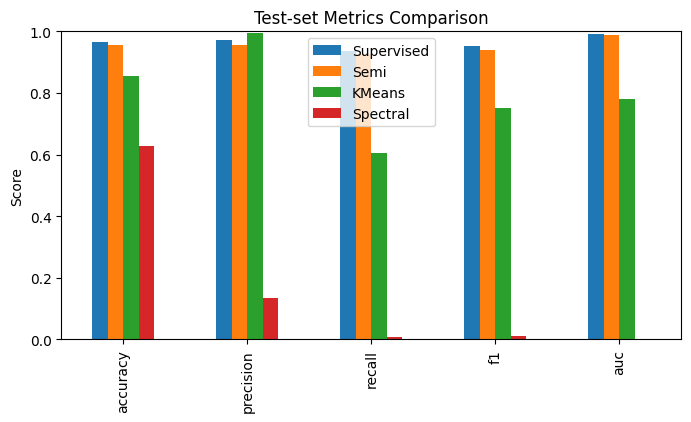

In [11]:
df_tr_sp, df_te_sp = spectral_experiment(X, y, M=30)

comparison = pd.DataFrame({
    'Supervised': df_te_mc,
    'Semi':       df_te_semi,
    'KMeans':     df_te_km,
    'Spectral':   df_te_sp
})
display(comparison)

comparison.plot.bar(figsize=(8,4))
plt.title('Test‐set Metrics Comparison')
plt.ylabel('Score')
plt.ylim(0,1)
plt.show()

## 2. Active Learning Using Support Vector Machines

### (a) Download the banknote authentication Data Set

In [12]:
BN_PATH = "../data/data_banknote_authentication.txt"
bn = pd.read_csv(BN_PATH, header=None)
bn.columns = ['variance','skewness','curtosis','entropy','class']

Xb = bn.iloc[:,:4].values
yb = bn['class'].values

Xb_tr, Xb_te, yb_tr, yb_te = train_test_split(Xb, yb, test_size=472/len(yb), stratify=yb, random_state=0)

### (b) Repeat each of the following two procedures 50 times

In [13]:
def make_cv(y_pool, max_splits=5, random_state=0):
    counts = np.bincount(y_pool)
    min_count = counts.min()
    n_splits = min(max_splits, len(y_pool), min_count)
    n_splits = max(2, n_splits)
    return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

#### (i) Passive

In [14]:
def passive_learning(X, y, X_te, y_te, steps=90, batch=10, repeats=50):
    errs = np.zeros((repeats, steps))
    for r in range(repeats):
        pool = []
        unlabeled = list(range(len(y)))
        for i in range(steps):

            while True:
                batch_idx = np.random.choice(unlabeled, batch, replace=False)
                if len(np.unique(y[batch_idx])) == 2:
                    break
            pool.extend(batch_idx)
            for idx in batch_idx:
                unlabeled.remove(idx)

            Xp, yp = X[pool], y[pool]
            cv = make_cv(yp, max_splits=5, random_state=r)
            grid = GridSearchCV(
                LinearSVC(penalty='l1', dual=False, max_iter=5000),
                {'C': np.logspace(-3,3,5)},
                cv=cv,
                scoring='accuracy',
                error_score=np.nan
            ).fit(Xp, yp)

            pred = grid.best_estimator_.predict(X_te)
            errs[r, i] = 1 - accuracy_score(y_te, pred)
    return errs.mean(axis=0)

#### (ii) Active

In [15]:
def active_learning(X, y, X_te, y_te, steps=90, batch=10, repeats=50):
    errs = np.zeros((repeats, steps))
    for r in range(repeats):
        unlabeled = list(range(len(y)))
        while True:
            init = np.random.choice(unlabeled, batch, replace=False)
            if len(np.unique(y[init])) == 2:
                break
        pool = init.tolist()
        for idx in init:
            unlabeled.remove(idx)

        for i in range(steps):
            Xp, yp = X[pool], y[pool]
            cv = make_cv(yp, max_splits=5, random_state=r)
            grid = GridSearchCV(
                LinearSVC(penalty='l1', dual=False, max_iter=5000),
                {'C': np.logspace(-3,3,5)},
                cv=cv,
                scoring='accuracy',
                error_score=np.nan
            ).fit(Xp, yp)
            model = grid.best_estimator_

            pred = model.predict(X_te)
            errs[r, i] = 1 - accuracy_score(y_te, pred)

            if unlabeled:
                dists = np.abs(model.decision_function(X[unlabeled]))
                choose = unlabeled.pop(np.argmin(dists))
                pool.append(choose)

    return errs.mean(axis=0)

### (c) Average the 50 test errors

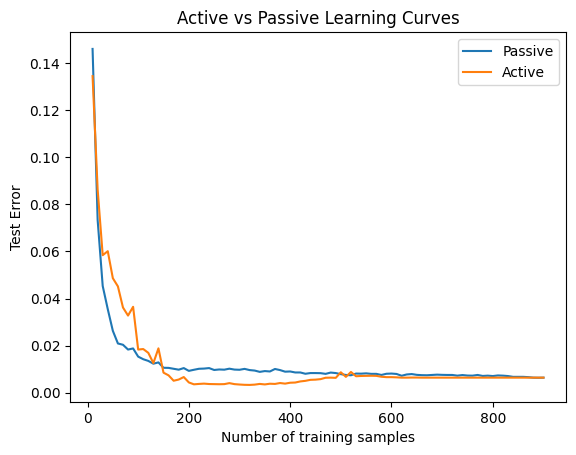

In [16]:
passive_err = passive_learning(Xb_tr, yb_tr, Xb_te, yb_te)
active_err  = active_learning(Xb_tr, yb_tr, Xb_te, yb_te)

x = 10 * np.arange(1, 91)
plt.plot(x, passive_err, label='Passive')
plt.plot(x, active_err,  label='Active')
plt.xlabel('Number of training samples')
plt.ylabel('Test Error')
plt.title('Active vs Passive Learning Curves')
plt.legend()
plt.show()